In [24]:
import os
import matplotlib.pyplot as plt
plt.style.use('default')
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import glob
import h5py
import calendar
from osgeo import ogr
import fiona
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.io import MemoryFile
from rasterio.transform import from_origin, Affine
from rasterio.windows import Window
from rasterio.crs import CRS
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import datetime
from scipy import stats
import openpyxl
# Ignore runtime warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [2]:
yearname = np.linspace(2015, 2021, 7, dtype='int')
monthnum = np.linspace(1, 12, 12, dtype='int')
monthname = np.arange(1, 13)
monthname = [str(i).zfill(2) for i in monthname]

# Generate a sequence of string between start and end dates (Year + DOY)
start_date = '2015-04-01'
end_date = '2021-12-31'
year = 2021 - 2015 + 1

start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d').date()
end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d').date()
delta_date = end_date - start_date

date_seq = []
date_seq_doy = []
for i in range(delta_date.days + 1):
    date_str = start_date + datetime.timedelta(days=i)
    date_seq.append(date_str.strftime('%Y%m%d'))
    date_seq_doy.append(str(date_str.timetuple().tm_year) + str(date_str.timetuple().tm_yday).zfill(3))

# Count how many days for a specific year
yearname = np.linspace(2015, 2021, 7, dtype='int')
monthnum = np.linspace(1, 12, 12, dtype='int')
monthname = np.arange(1, 13)
monthname = [str(i).zfill(2) for i in monthname]

daysofyear = []
for idt in range(len(yearname)):
    if idt == 0:
        f_date = datetime.date(yearname[idt], monthnum[3], 1)
        l_date = datetime.date(yearname[idt], monthnum[-1], 31)
        delta_1y = l_date - f_date
        daysofyear.append(delta_1y.days + 1)
    else:
        f_date = datetime.date(yearname[idt], monthnum[0], 1)
        l_date = datetime.date(yearname[idt], monthnum[-1], 31)
        delta_1y = l_date - f_date
        daysofyear.append(delta_1y.days + 1)

daysofyear = np.asarray(daysofyear)

# Find the indices of each month in the list of days between 2015 - 2018
nlpyear = 1999 # non-leap year
lpyear = 2000 # leap year
daysofmonth_nlp = np.array([calendar.monthrange(nlpyear, x)[1] for x in range(1, len(monthnum)+1)])
ind_nlp = [np.arange(daysofmonth_nlp[0:x].sum(), daysofmonth_nlp[0:x+1].sum()) for x in range(0, len(monthnum))]
daysofmonth_lp = np.array([calendar.monthrange(lpyear, x)[1] for x in range(1, len(monthnum)+1)])
ind_lp = [np.arange(daysofmonth_lp[0:x].sum(), daysofmonth_lp[0:x+1].sum()) for x in range(0, len(monthnum))]
ind_iflpr = np.array([int(calendar.isleap(yearname[x])) for x in range(len(yearname))]) # Find out leap years
# Generate a sequence of the days of months for all years
daysofmonth_seq = np.array([np.tile(daysofmonth_nlp[x], len(yearname)) for x in range(0, len(monthnum))])
daysofmonth_seq[1, :] = daysofmonth_seq[1, :] + ind_iflpr # Add leap days to February

daysofmonth_seq_cumsum = np.cumsum(daysofmonth_seq, axis=0)

In [3]:
########################################################################################################################
# (Function 1) Subset the coordinates table of study area

def coordtable_subset(lat_input, lon_input, lat_extent_max, lat_extent_min, lon_extent_max, lon_extent_min):
    lat_output = lat_input[np.where((lat_input <= lat_extent_max) & (lat_input >= lat_extent_min))]
    row_output_ind = np.squeeze(np.array(np.where((lat_input <= lat_extent_max) & (lat_input >= lat_extent_min))))
    lon_output = lon_input[np.where((lon_input <= lon_extent_max) & (lon_input >= lon_extent_min))]
    col_output_ind = np.squeeze(np.array(np.where((lon_input <= lon_extent_max) & (lon_input >= lon_extent_min))))

    return lat_output, row_output_ind, lon_output, col_output_ind

In [4]:
########################################################################################################################
# Function 2. Subset and reproject the Geotiff data to WGS84 projection

def sub_n_reproj(input_mat, kwargs_sub, sub_window, output_crs):
    # Get the georeference and bounding parameters of subset image
    kwargs_sub.update({
        'height': sub_window.height,
        'width': sub_window.width,
        'transform': rasterio.windows.transform(sub_window, kwargs_sub['transform'])})

    # Generate subset rasterio dataset
    input_ds_subset = MemoryFile().open(**kwargs_sub)
    input_mat = np.expand_dims(input_mat, axis=0)
    input_ds_subset.write(input_mat)

    # Reproject a dataset
    transform_reproj, width_reproj, height_reproj = \
        calculate_default_transform(input_ds_subset.crs, output_crs,
                                    input_ds_subset.width, input_ds_subset.height, *input_ds_subset.bounds)
    kwargs_reproj = input_ds_subset.meta.copy()
    kwargs_reproj.update({
            'crs': output_crs,
            'transform': transform_reproj,
            'width': width_reproj,
            'height': height_reproj
        })

    output_ds = MemoryFile().open(**kwargs_reproj)
    reproject(source=rasterio.band(input_ds_subset, 1), destination=rasterio.band(output_ds, 1),
              src_transform=input_ds_subset.transform, src_crs=input_ds_subset.crs,
              dst_transform=transform_reproj, dst_crs=output_crs, resampling=Resampling.nearest)

    return output_ds


In [5]:
########################################################################################################################
path_shp_lp = 'C:/Users/Jessica Besnier/Documents/Fall 2021/AGU data/river_basin_shape-file'
path_shp_upn= 'C:/Users/Jessica Besnier/Documents/Spring 2022/Research/sub basin/upper_parana_.shp'
path_shp_upg= 'C:/Users/Jessica Besnier/Documents/Spring 2022/Research/sub basin/upper_paraguay_.shp'
path_shp_lpg= 'C:/Users/Jessica Besnier/Documents/Spring 2022/Research/sub basin/lower_paraguay_.shp'
path_shp_uug= 'C:/Users/Jessica Besnier/Documents/Spring 2022/Research/sub basin/upper_uruguay_.shp'
path_shp_lug= 'C:/Users/Jessica Besnier/Documents/Spring 2022/Research/sub basin/lower_uruguay_.shp'
path_shp_lpn= 'C:/Users/Jessica Besnier/Documents/Spring 2022/Research/sub basin/lower_parana_.shp'
path_shp_rpl= 'C:/Users/Jessica Besnier/Documents/Spring 2022/Research/sub basin/rio_de_la_plata_.shp'

path_shp_trib = 'D:/2021/catchment_watersheds/'
path_shp_ag = 'D:/2021/catchment_watersheds/Arroio Guacu Watershed.shp'
path_shp_sf = 'D:/2021/catchment_watersheds/Sao Francisco Watershed.shp'
path_shp_pq = 'D:/2021/catchment_watersheds/Piquiri Watershed.shp'
path_shp_ig = 'D:/2021/catchment_watersheds/Iguatemi Watershed.shp'
path_shp_px = 'D:/2021/catchment_watersheds/Peixe Watershed.shp'
path_shp_te = 'D:/2021/catchment_watersheds/Tiete Watershed.shp'

path_smap9 = 'D:/2021/la_plata/la_plata_9km_monthly/la_plata_9km_monthly'
path_smap1 = 'D:/2021/la_plata/la_plata_1km_monthly/la_plata_1km_monthly'

path_code = 'D:/2021/la_plata/smap_codes'
path_results = '/Users/binfang/Documents/SMAP_Project/results/results_220509'

In [6]:
# Load in geo-location parameters
os.chdir(path_code)
f = h5py.File("ds_parameters.hdf5", "r")
varname_list = ['lat_world_ease_1km', 'lon_world_ease_1km', 'lat_world_ease_9km', 'lon_world_ease_9km']

for x in range(len(varname_list)):
    var_obj = f[varname_list[x]][()]
    exec(varname_list[x] + '= var_obj')
    del(var_obj)
f.close()

In [7]:
# Read SMAP 9km data
smap_files9 = sorted(glob.glob(path_smap9 + '/*.tif'))

raster_9km_all = []
for idt in range(len(smap_files9)):
    raster_9km = rasterio.open(smap_files9[idt]).read()
    raster_9km = np.squeeze(raster_9km)
    #raster_9km = np.nanmean(raster_9km, axis=0)
    raster_9km_all.append(raster_9km)
    del(raster_9km)
    print(smap_files9[idt])
raster_9km_all = np.stack(raster_9km_all, axis=0)

D:/2021/la_plata/la_plata_9km_monthly/la_plata_9km_monthly\smap_sm_9km_ds_2015_04.tif
D:/2021/la_plata/la_plata_9km_monthly/la_plata_9km_monthly\smap_sm_9km_ds_2015_05.tif
D:/2021/la_plata/la_plata_9km_monthly/la_plata_9km_monthly\smap_sm_9km_ds_2015_06.tif
D:/2021/la_plata/la_plata_9km_monthly/la_plata_9km_monthly\smap_sm_9km_ds_2015_07.tif
D:/2021/la_plata/la_plata_9km_monthly/la_plata_9km_monthly\smap_sm_9km_ds_2015_08.tif
D:/2021/la_plata/la_plata_9km_monthly/la_plata_9km_monthly\smap_sm_9km_ds_2015_09.tif
D:/2021/la_plata/la_plata_9km_monthly/la_plata_9km_monthly\smap_sm_9km_ds_2015_10.tif
D:/2021/la_plata/la_plata_9km_monthly/la_plata_9km_monthly\smap_sm_9km_ds_2015_11.tif
D:/2021/la_plata/la_plata_9km_monthly/la_plata_9km_monthly\smap_sm_9km_ds_2015_12.tif
D:/2021/la_plata/la_plata_9km_monthly/la_plata_9km_monthly\smap_sm_9km_ds_2016_01.tif
D:/2021/la_plata/la_plata_9km_monthly/la_plata_9km_monthly\smap_sm_9km_ds_2016_02.tif
D:/2021/la_plata/la_plata_9km_monthly/la_plata_9km_mon

In [8]:
# Read SMAP 1km data

smap_files1 = sorted(glob.glob(path_smap1 + '/*.tif'))

raster_1km_all = []
for idt in range(len(smap_files1)):
    raster_1km = rasterio.open(smap_files1[idt]).read()
    raster_1km = np.squeeze(raster_1km)
    #raster_9km = np.nanmean(raster_9km, axis=0)
    raster_1km_all.append(raster_1km)
    del(raster_1km)
    print(smap_files1[idt])
raster_1km_all = np.stack(raster_1km_all, axis=0)

smap_files1 = sorted(glob.glob(path_smap1 + '/*.tif'))


D:/2021/la_plata/la_plata_1km_monthly/la_plata_1km_monthly\smap_sm_1km_ds_2015_04.tif
D:/2021/la_plata/la_plata_1km_monthly/la_plata_1km_monthly\smap_sm_1km_ds_2015_05.tif
D:/2021/la_plata/la_plata_1km_monthly/la_plata_1km_monthly\smap_sm_1km_ds_2015_06.tif
D:/2021/la_plata/la_plata_1km_monthly/la_plata_1km_monthly\smap_sm_1km_ds_2015_07.tif
D:/2021/la_plata/la_plata_1km_monthly/la_plata_1km_monthly\smap_sm_1km_ds_2015_08.tif
D:/2021/la_plata/la_plata_1km_monthly/la_plata_1km_monthly\smap_sm_1km_ds_2015_09.tif
D:/2021/la_plata/la_plata_1km_monthly/la_plata_1km_monthly\smap_sm_1km_ds_2015_10.tif
D:/2021/la_plata/la_plata_1km_monthly/la_plata_1km_monthly\smap_sm_1km_ds_2015_11.tif
D:/2021/la_plata/la_plata_1km_monthly/la_plata_1km_monthly\smap_sm_1km_ds_2015_12.tif
D:/2021/la_plata/la_plata_1km_monthly/la_plata_1km_monthly\smap_sm_1km_ds_2016_01.tif
D:/2021/la_plata/la_plata_1km_monthly/la_plata_1km_monthly\smap_sm_1km_ds_2016_02.tif
D:/2021/la_plata/la_plata_1km_monthly/la_plata_1km_mon

In [9]:
# Load in watershed shapefile boundaries
shapefile_name = fiona.open(path_shp_lp + '/la_plata.shp', 'r')
crop_shape = [feature["geometry"] for feature in shapefile_name]
shp_extent = list(shapefile_name.bounds)

In [54]:
shapefile_name.bounds

(-67.03111738760259,
 -35.67715032112065,
 -43.606117387602566,
 -14.089650321120622)

In [10]:
# # subset SM of the region of La Plata
lat_sub_max = shp_extent[3]
lat_sub_min = shp_extent[1]
lon_sub_max = shp_extent[2]
lon_sub_min = shp_extent[0]
[lat_9km, row_9km_ind, lon_9km, col_9km_ind] = \
    coordtable_subset(lat_world_ease_9km, lon_world_ease_9km, lat_sub_max, lat_sub_min, lon_sub_max, lon_sub_min)
[lat_1km, row_1km_ind, lon_1km, col_1km_ind] = \
    coordtable_subset(lat_world_ease_1km, lon_world_ease_1km, lat_sub_max, lat_sub_min, lon_sub_max, lon_sub_min)

output_crs = 'EPSG:4326'

In [53]:
shp_extent

[-67.03111738760259,
 -35.67715032112065,
 -43.606117387602566,
 -14.089650321120622]

In [11]:
shp_extent_adjusted = [shp_extent[0], shp_extent[2], shp_extent[1], shp_extent[3]]

In [56]:
shp_extent_adjusted

[-67.03111738760259,
 -43.606117387602566,
 -35.67715032112065,
 -14.089650321120622]

In [12]:
# 1 km
masked_ds_lp_1km_all = []
for n in range(raster_1km_all.shape[0]):
    kwargs_1km_sub = {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': len(lon_world_ease_1km),
                      'height': len(lat_world_ease_1km), 'count': 1, 'crs': CRS.from_dict(init='epsg:6933'),
                      'transform': Affine(1000.89502334956, 0.0, -17367530.44516138, 0.0, -1000.89502334956, 7314540.79258289)}
    sub_window_lp_1km = Window(col_1km_ind[0], row_1km_ind[0], len(col_1km_ind), len(row_1km_ind))
    smap_sm_lp_1km_output = sub_n_reproj(raster_1km_all[n, :, :], kwargs_1km_sub, sub_window_lp_1km, output_crs)
    masked_ds_lp_1km, mask_transform_ds_lp_1km = mask(dataset=smap_sm_lp_1km_output, shapes=crop_shape, crop=True)
    masked_ds_lp_1km[np.where(masked_ds_lp_1km == 0)] = np.nan
    masked_ds_lp_1km = masked_ds_lp_1km.squeeze()

    masked_ds_lp_1km_all.append(masked_ds_lp_1km)

masked_ds_lp_1km_all = np.asarray(masked_ds_lp_1km_all)

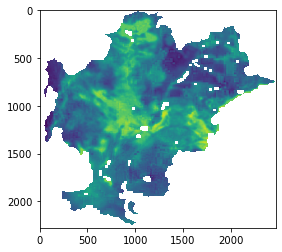

In [12]:
plt.imshow(masked_ds_lp_1km_all[0, :, :])

In [13]:
# 9 km
masked_ds_lp_9km_all = []
for n in range(raster_9km_all.shape[0]):
    kwargs_9km_sub = {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': len(lon_world_ease_9km),
                      'height': len(lat_world_ease_9km), 'count': 1, 'crs': CRS.from_dict(init='epsg:6933'),
                      'transform': Affine(9008.05, 0.0, -17367530.44516138, 0.0, -9008.05, 7314540.79258289)}
    sub_window_lp_9km = Window(col_9km_ind[0], row_9km_ind[0], len(col_9km_ind), len(row_9km_ind))
    smap_sm_lp_9km_output = sub_n_reproj(raster_9km_all[n, :, :], kwargs_9km_sub, sub_window_lp_9km, output_crs)
    masked_ds_lp_9km, mask_transform_ds_lp_9km = mask(dataset=smap_sm_lp_9km_output, shapes=crop_shape, crop=True)
    masked_ds_lp_9km[np.where(masked_ds_lp_9km == 0)] = np.nan
    masked_ds_lp_9km = masked_ds_lp_9km.squeeze()

    masked_ds_lp_9km_all.append(masked_ds_lp_9km)

masked_ds_lp_9km_all = np.asarray(masked_ds_lp_9km_all)

In [145]:
# # TEST 1km - 9 km
# masked_ds_lp_1km_all = []
# for n in range(raster_9km_all.shape[0]):
#     kwargs_9km_sub = {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': len(lon_world_ease_9km),
#                       'height': len(lat_world_ease_9km), 'count': 1, 'crs': CRS.from_dict(init='epsg:6933'),
#                       'transform': Affine(9008.05, 0.0, -17367530.44516138, 0.0, -9008.05, 7314540.79258289)}
#     sub_window_lp_1km = Window(col_9km_ind[0], row_9km_ind[0], len(col_9km_ind), len(row_9km_ind))
#     smap_sm_lp_1km_output = sub_n_reproj(raster_1km_all[n, :, :], kwargs_9km_sub, sub_window_lp_9km, output_crs)
#     masked_ds_lp_1km, mask_transform_ds_lp_1km = mask(dataset=smap_sm_lp_1km_output, shapes=crop_shape, crop=True)
#     masked_ds_lp_1km[np.where(masked_ds_lp_1km == 0)] = np.nan
#     masked_ds_lp_1km = masked_ds_lp_1km.squeeze()

#     masked_ds_lp_1km_all.append(masked_ds_lp_1km)

# masked_ds_lp_1km_all = np.asarray(masked_ds_lp_1km_all)

In [146]:

#plt.imshow(rasterio.open(smap_files1[11]).read()[0, :, :])


In [14]:
smap_files9[0]

'/Users/binfang/Downloads/Processing/smap_output/la_plata_9km_monthly/smap_sm_9km_ds_2015_04.tif'

In [15]:
#plt.imshow(raster_9km_all[11, :, :])

In [16]:
# Pick the months of 2d-arrays to be plotted
start_month = 9 + 12 * 5
end_month = 9 + 12 * 6
masked_ds_lp_1km_all_sub = masked_ds_lp_1km_all[start_month:end_month, :, :]
masked_ds_lp_9km_all_sub = masked_ds_lp_9km_all[start_month:end_month, :, :]

In [17]:
shapefile_name.bounds

(-67.03111738760259,
 -35.67715032112065,
 -43.606117387602566,
 -14.089650321120622)

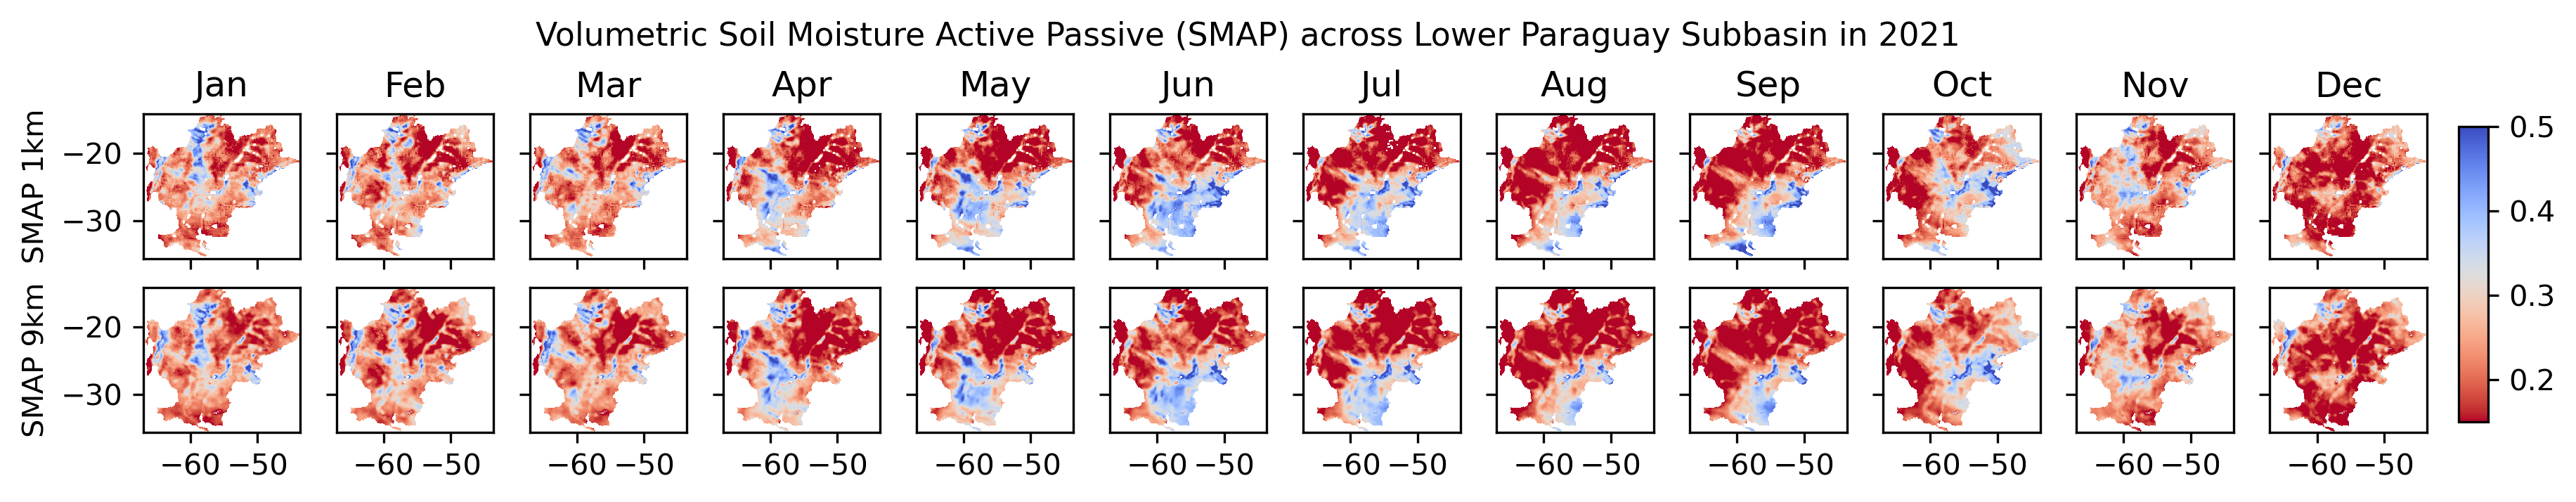

In [18]:
# Create  figure and color style
fig, axs = plt.subplots(ncols=12, nrows=2, figsize=(14, 2), sharey=True, sharex=True, dpi=300) 

warmcool = plt.cm.get_cmap('coolwarm').reversed()

year = 2021

# Generate plots 1km SMAP
#path = 'D:/2021/la_plata/sm_1km_data/monthly_smap_resample/2020/' # assign path based on given resolution
#month_files = [name for name in os.listdir(path) if name.endswith('.tif')] # recognize monthly average files at given path
# subbasins = gpd.read_file('C:/Users/Jessica Besnier/Documents/Spring 2022/Research/sub basin/upper_parana_.shp')
for j in range(len(masked_ds_lp_1km_all_sub)): # iterate through month values
#     f = path + month_files[j] 
#     raster = rasterio.open(smap_files1[0])
    img =  masked_ds_lp_1km_all_sub[j, :, :]
#     img[img == 0] = np.nan
    w=shapefile_name.bounds[0]
    s=shapefile_name.bounds[1]
    e=shapefile_name.bounds[2]
    n=shapefile_name.bounds[3]
    plot = axs[0,j].imshow(img, extent=[w,e,s,n], vmin = 0.15, vmax = 0.5, cmap=warmcool)
#     subbasins.plot(ax=axs[0,j], facecolor='None', edgecolor='black')

  

# Generate plots 9KM SMAP
#path = 'D:/2021/la_plata/sm_9km_data/monthly_9km_year_update/2019/' # assign path based on given resolution
#month_files = [name for name in os.listdir(path) if name.endswith('.tif')] # recognize monthly average files at given path
#subbasins = gpd.read_file('C:/Users/Jessica Besnier/Documents/Spring 2022/Research/sub basin/upper_parana_.shp')
for j in range(len(masked_ds_lp_9km_all_sub)): # iterate through month values
    # f = path + month_files[j] 
#     raster =  rasterio.open(smap_files9[0])
    img = masked_ds_lp_9km_all_sub[j, :, :]
    # img = raster.read(1)
    # img[img == 0] = np.nan
    w=shapefile_name.bounds[0]
    s=shapefile_name.bounds[1]
    e=shapefile_name.bounds[2]
    n=shapefile_name.bounds[3]
    #subbasins.plot(ax=axs[1,j], facecolor='None', edgecolor='black')
    plot = axs[1,j].imshow(img, extent=[w,e,s,n], vmin = 0.15, vmax = 0.5, cmap=warmcool)

    # if j == 11:
    #     plot = axs[1,0].imshow(img, extent=[w,e,s,n], vmin = 0.15, vmax = 0.5, cmap=warmcool)
    # else:
    #     plot = axs[1,j+1].imshow(img, extent=[w,e,s,n], vmin = 0.15, vmax = 0.5, cmap=warmcool)


# Add title
fig.suptitle('Volumetric Soil Moisture Active Passive (SMAP) across Lower Paraguay Subbasin in 2021', size=11, y=1.1)


axs[0,0].set_ylabel('SMAP 1km')
axs[1,0].set_ylabel('SMAP 9km')

# Format ticks
#axs[1,0].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#plt.xticks([99.5])

# Add colorbars
cb_ax = fig.add_axes([0.91, 0.15, 0.01, 0.70])
cbar1 = fig.colorbar(plot, cax=cb_ax)

# Add labels
month = pd.date_range('2021-01-01','2021-12-31', freq='MS').strftime("%b").tolist()
for k in range(len(month)):
    axs[0,k].set_title(month[k])
# Save figure
# plt.savefig('D:/2021/la_plata/figures/SMAP/SMAP2019.png')

In [14]:
divider_ind = np.arange(0, 84, 12) - 3
divider_ind[0] = 0

In [15]:
divider_ind_yearly = np.split(np.arange(81), divider_ind)[1:]

In [16]:
divider_ind_yearly

[array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
 array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
 array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]),
 array([57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]),
 array([69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80])]

In [17]:
masked_ds_lp_1km_all_yearly = [masked_ds_lp_1km_all[x, :, :] for x in divider_ind_yearly]

In [18]:
len(masked_ds_lp_1km_all_yearly[0])

9

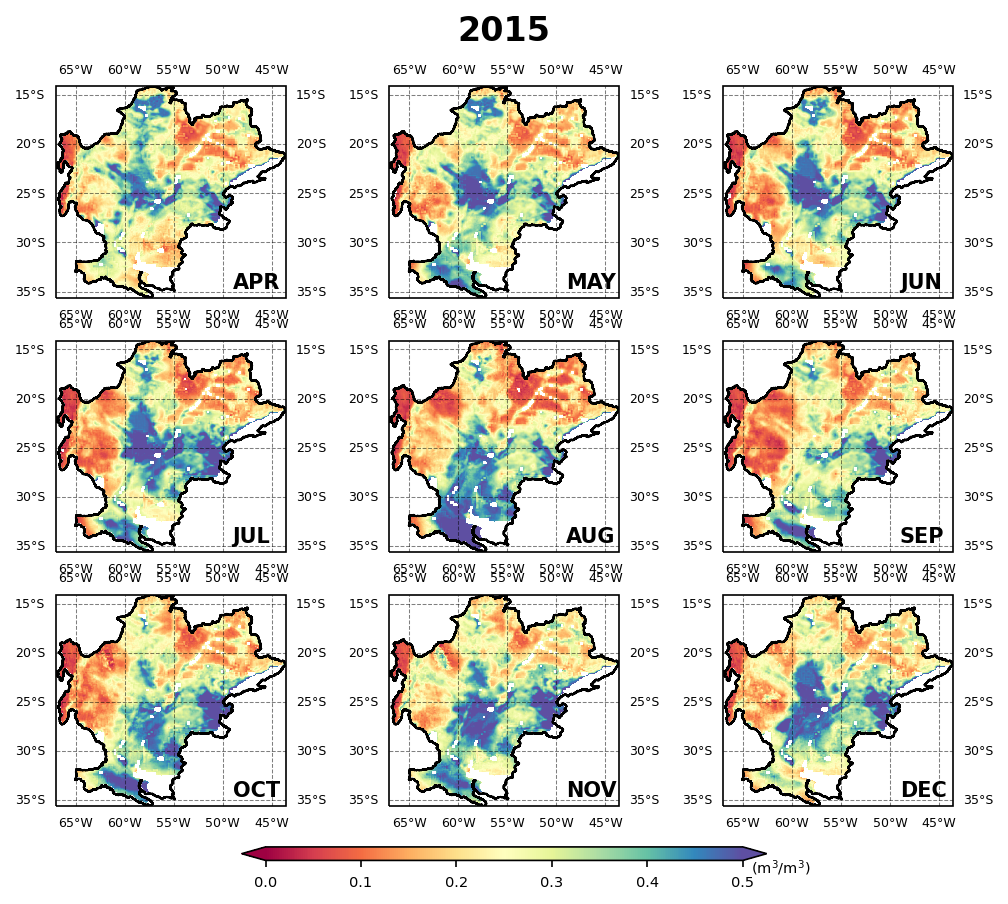

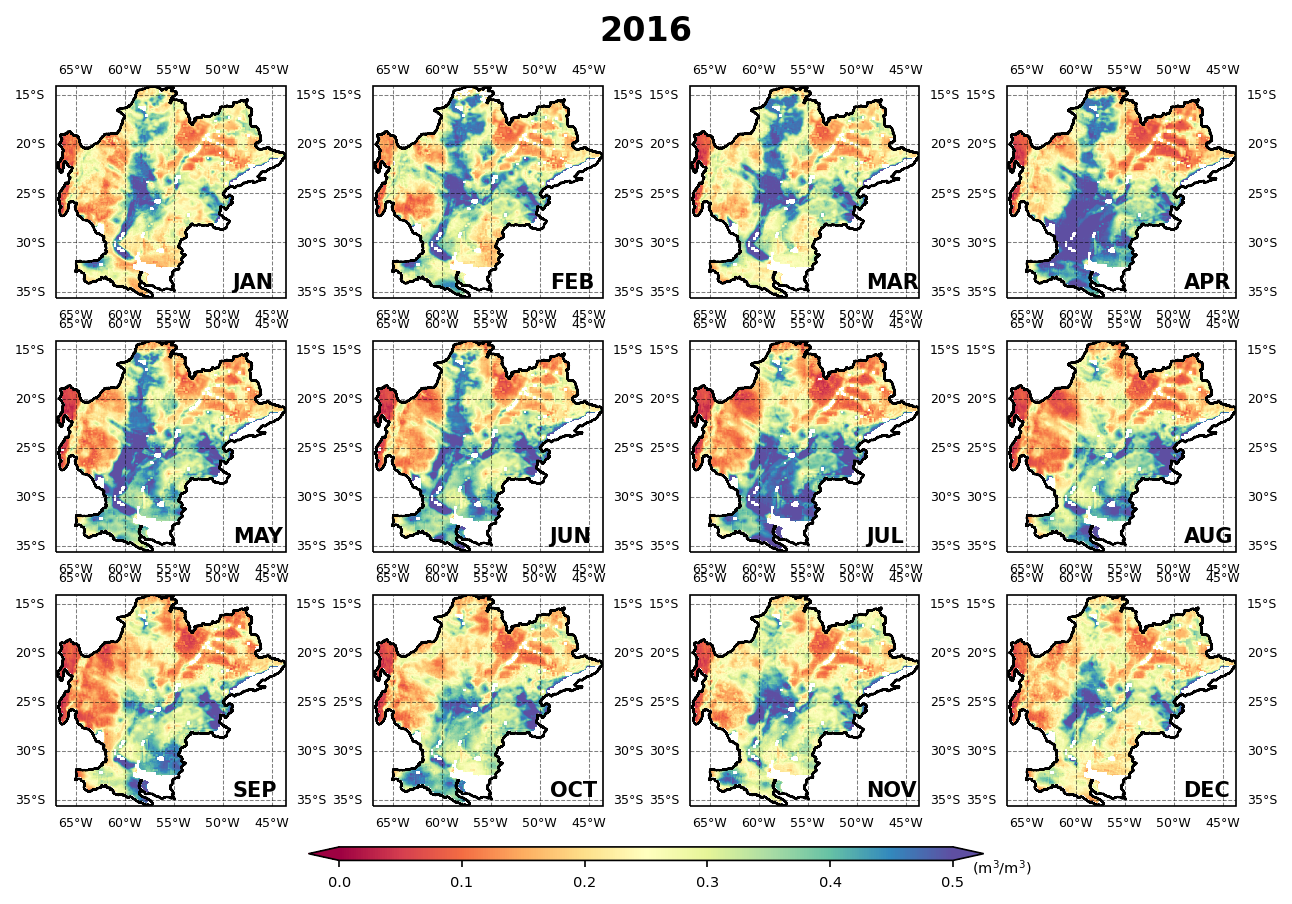

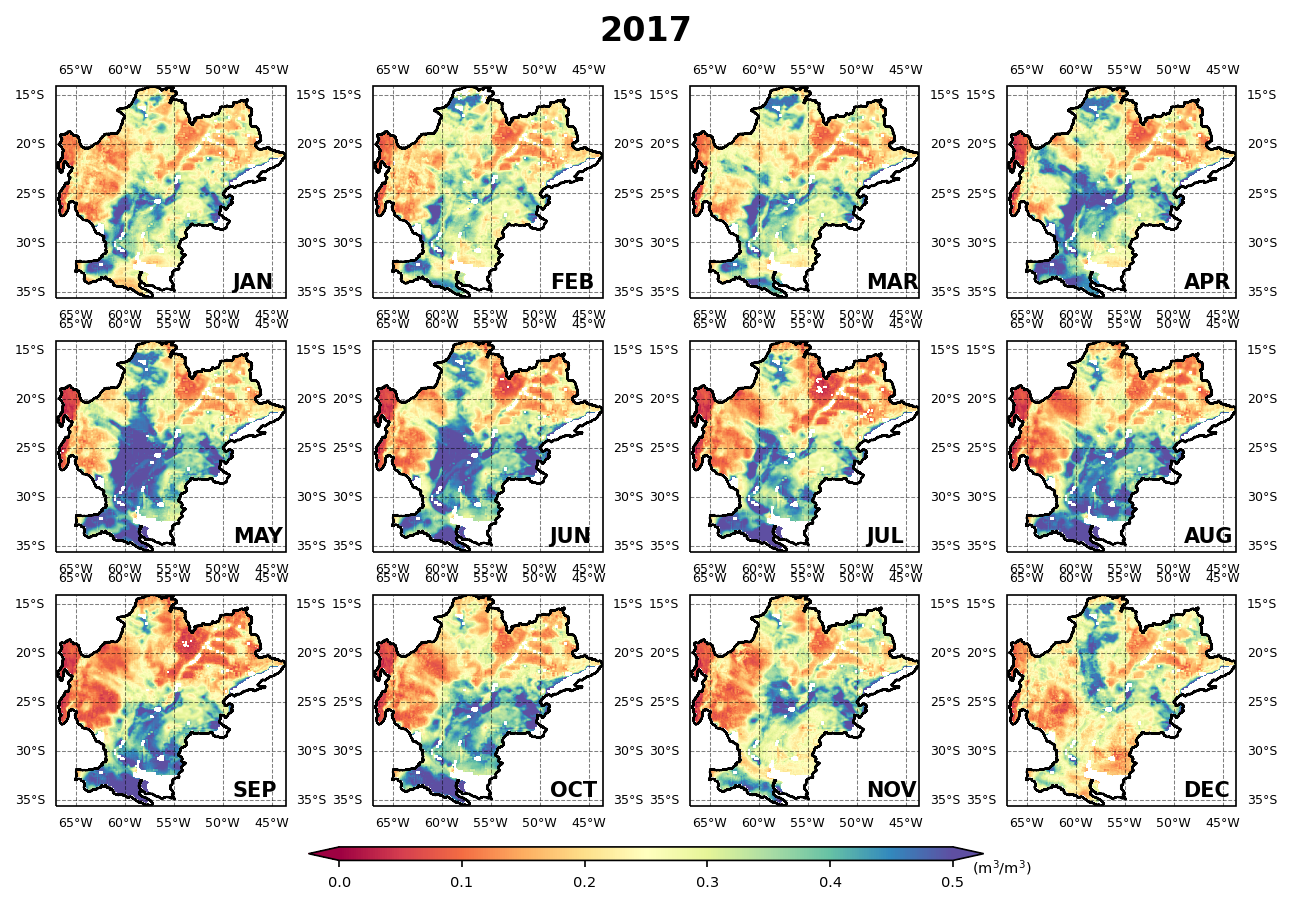

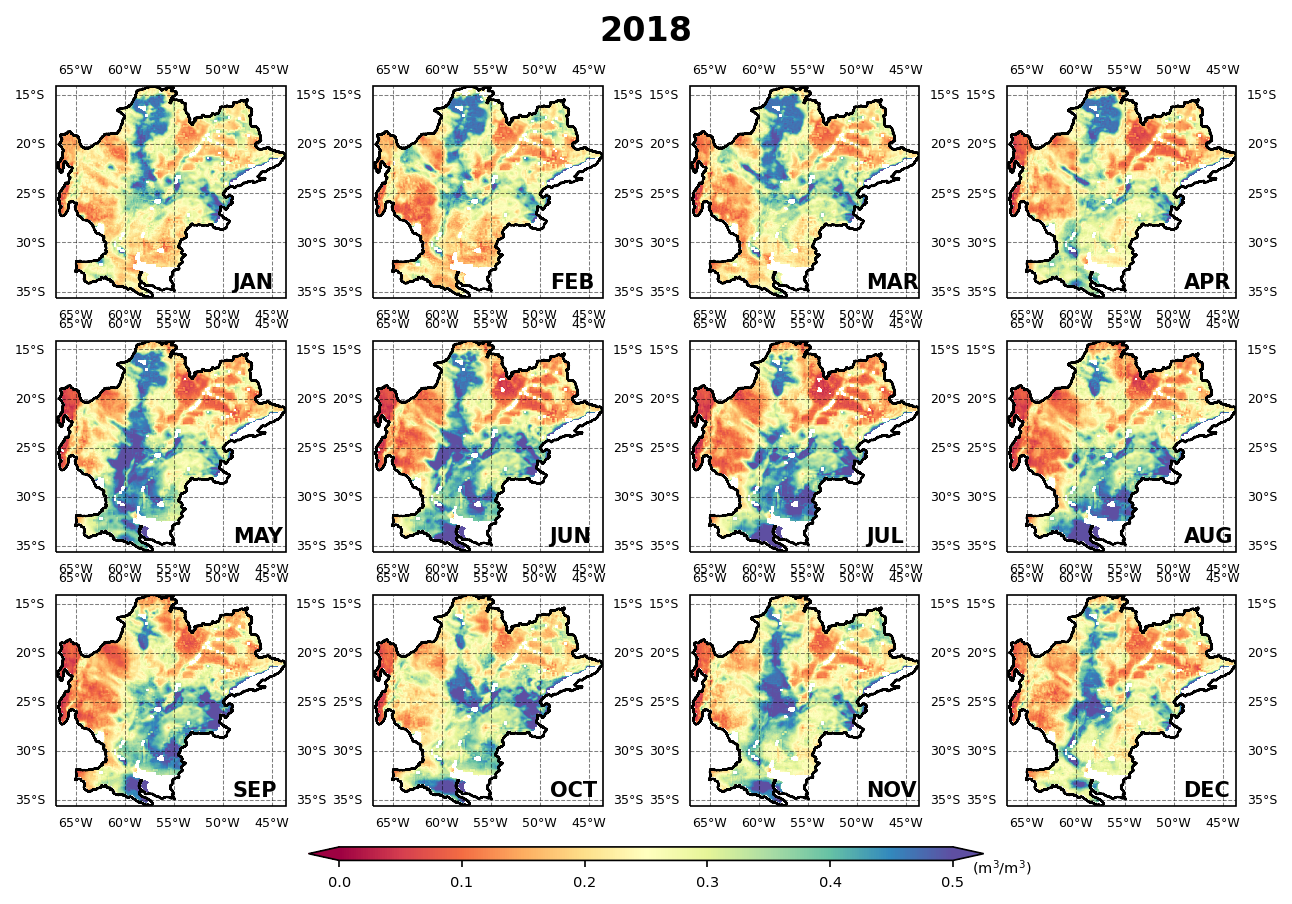

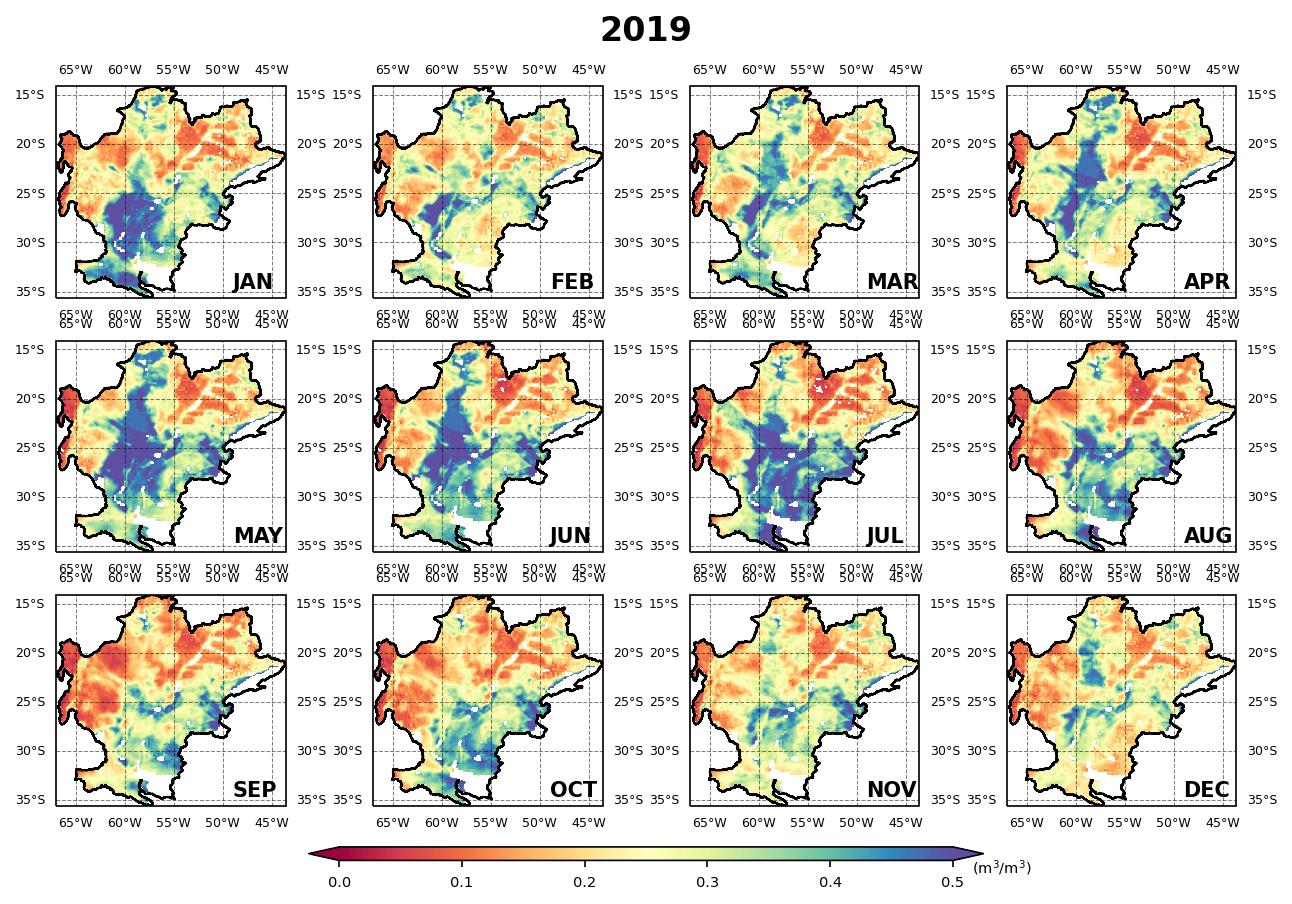

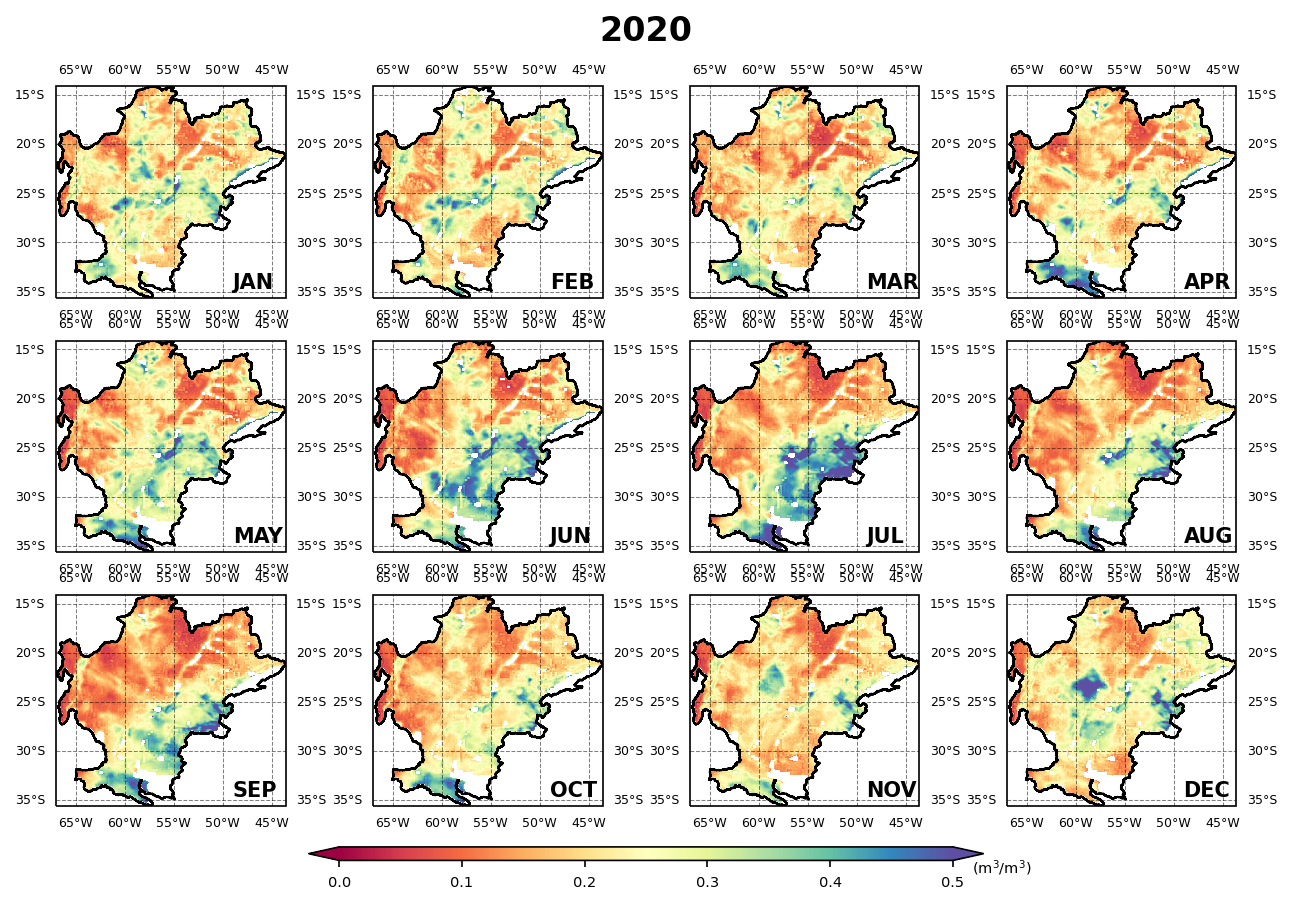

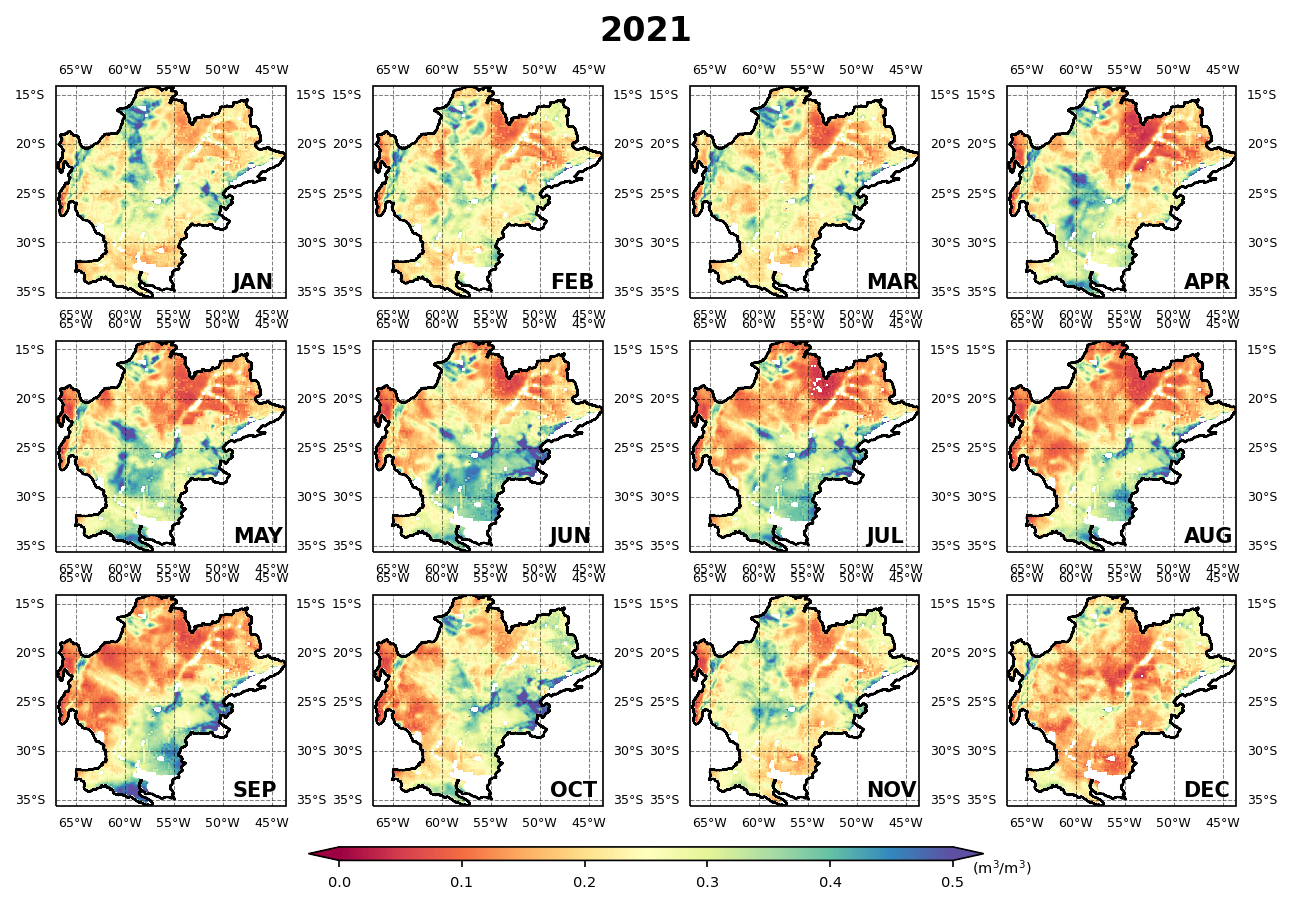

In [21]:
# 3. Make the subplot maps
title_content = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
feature_shp= ShapelyFeature(Reader(path_shp_lp + '/la_plata.shp').geometries(),
                                ccrs.PlateCarree(), edgecolor='black', facecolor='none')
# shapefile_name = fiona.open(path_shp_lp + '/la_plata.shp', 'r')
# crop_shape = [feature["geometry"] for feature in shapefile_name]
# shp_extent = list(shapefile_name.bounds)

for iyr in range(len(yearname)):
    if iyr != 0: # 2015
        fig = plt.figure(figsize=(9, 6), facecolor='w', edgecolor='k', dpi=150)
        title_content_1year = title_content
    else: # Other years
        fig = plt.figure(figsize=(7, 6), facecolor='w', edgecolor='k', dpi=150)
        title_content_1year = title_content[3:]
    plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, hspace=0.2, wspace=0.2)
    for ipt in range(len(masked_ds_lp_1km_all_yearly[iyr])):
        ax = fig.add_subplot(3, len(masked_ds_lp_1km_all_yearly[iyr])//3, ipt+1, projection=ccrs.PlateCarree())
        ax.add_feature(feature_shp)
        img = ax.imshow(masked_ds_lp_1km_all_yearly[iyr][ipt], origin='upper', vmin=0, vmax=0.5, cmap='Spectral',
                    extent=shp_extent_adjusted)
        gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5, alpha=0.5, color='black')
        gl.xlocator = mticker.MultipleLocator(base=5)
        gl.ylocator = mticker.MultipleLocator(base=5)
        gl.xlabel_style = {'size': 6}
        gl.ylabel_style = {'size': 6}
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        ax.text(-49, -33, title_content_1year[ipt], fontsize=10, horizontalalignment='left',
                verticalalignment='top', weight='bold')

    cbar_ax = fig.add_axes([0.25, 0.04, 0.5, 0.015])
    cbar = plt.colorbar(img, cax=cbar_ax, extend='both', orientation='horizontal', pad=0.1)
    cbar.ax.tick_params(labelsize=7)
    cbar_ax.locator_params(nbins=5)
    cbar.set_label('$\mathregular{(m^3/m^3)}$', fontsize=7, x=1.08, y=0.05, labelpad=-15)
    plt.suptitle(yearname[iyr], fontsize=16, weight='bold')
    plt.show()
    #plt.savefig(path_results + '/sm_la_plata_' + str(yearname[iyr]) + '.png')
    plt.close()

In [25]:
# 4. Plot validation results between 1 km, 9 km and in-situ data
path_ismn = 'D:/2021/la_plata/sm_validation'
path_results = 'D:/2021/la_plata/sm_validation/results'
df_smap_insitu_sta_am = pd.read_excel(path_ismn + '/smap_validation_insitu_new.xlsx', index_col=0, sheet_name='AM')
df_smap_1km_sta_am = pd.read_excel(path_ismn + '/smap_validation_1km_new.xlsx', index_col=0, sheet_name='AM')
df_smap_9km_sta_am = pd.read_excel(path_ismn + '/smap_validation_9km_new.xlsx', index_col=0, sheet_name='AM')
size_validation = np.shape(df_smap_insitu_sta_am)
stn_name = df_smap_insitu_sta_am.index
network_name = df_smap_insitu_sta_am['network'].tolist()
network_unique = df_smap_insitu_sta_am['network'].unique()
network_all_group = [np.where(df_smap_1km_sta_am['network'] == network_unique[x]) for x in range(len(network_unique))]

In [26]:
# 4.1 single plots
stat_array_1km = []
stat_array_9km = []
ind_slc_all = []
# for ist in range(size_validation[0]):
for ist in range(len(stn_name)):
    x = np.array(df_smap_insitu_sta_am.iloc[ist, 2:], dtype=np.float)
    y1 = np.array(df_smap_1km_sta_am.iloc[ist, 2:], dtype=np.float)
    y2 = np.array(df_smap_9km_sta_am.iloc[ist, 2:], dtype=np.float)
    x[x == 0] = np.nan
    y1[y1 == 0] = np.nan
    y2[y2 == 0] = np.nan

    ind_nonnan = np.where(~np.isnan(x) & ~np.isnan(y1) & ~np.isnan(y2))[0]
    if len(ind_nonnan) > 0:
        x = x[ind_nonnan]
        y1 = y1[ind_nonnan]
        y2 = y2[ind_nonnan]

        slope_1, intercept_1, r_value_1, p_value_1, std_err_1 = stats.linregress(x, y1)
        y1_estimated = intercept_1 + slope_1 * x
        number_1 = len(y1)
        r_sq_1 = r_value_1 ** 2
        ubrmse_1 = np.sqrt(np.mean((x - y1_estimated) ** 2))
        bias_1 = np.mean(x - y1)
        conf_int_1 = std_err_1 * 1.96  # From the Z-value
        stdev_1 = np.std(y1)
        stat_array_1 = [number_1, r_sq_1, ubrmse_1, stdev_1, bias_1, p_value_1, conf_int_1]

        slope_2, intercept_2, r_value_2, p_value_2, std_err_2 = stats.linregress(x, y2)
        y2_estimated = intercept_2 + slope_2 * x
        number_2 = len(y2)
        r_sq_2 = r_value_2 ** 2
        ubrmse_2 = np.sqrt(np.mean((x - y2_estimated) ** 2))
        bias_2 = np.mean(x - y2)
        conf_int_2 = std_err_2 * 1.96  # From the Z-value
        stdev_2 = np.std(y2)
        stat_array_2 = [number_2, r_sq_2, ubrmse_2, stdev_2, bias_2, p_value_2, conf_int_2]

        fig = plt.figure(figsize=(8, 5), dpi=200)
        fig.subplots_adjust(hspace=0.2, wspace=0.2)
        ax = fig.add_subplot(111)

        ax.scatter(x, y1, s=5, c='r', marker='o', label='1 km')
        ax.scatter(x, y2, s=5, c='k', marker='^', label='9 km')

        ax.plot(x, intercept_1 + slope_1 * x, '-', color='r')
        ax.plot(x, intercept_2 + slope_2 * x, '-', color='k')

        plt.xlim(0, 0.4)
        ax.set_xticks(np.arange(0, 0.5, 0.1))
        plt.ylim(0, 0.4)
        ax.set_yticks(np.arange(0, 0.5, 0.1))
        ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
        plt.grid(linestyle='--')
        plt.legend(loc='upper left')
        plt.suptitle(network_name[ist] +', ' + str(stn_name[ist]), fontsize=18, y=0.99, fontweight='bold')
        # plt.show()
        plt.savefig(path_results +'/' + network_name[ist] + '_' + str(stn_name[ist]) + '.png')
        plt.close(fig)
        stat_array_1km.append(stat_array_1)
        stat_array_9km.append(stat_array_2)
        ind_slc_all.append(ist)
        print(ist)
        del(stat_array_1, stat_array_2)
    else:
        pass

stat_array_1km = np.array(stat_array_1km)
stat_array_9km = np.array(stat_array_9km)

columns_validation = ['number', 'r_sq', 'ubrmse', 'stdev', 'bias', 'p_value', 'conf_int']
index_validation = df_smap_1km_sta_am.index
index_validation_new = index_validation[0:2]# Exclude the station 'Santa_Maria_UFSM'
network_validation = df_smap_1km_sta_am['network']

df_stat_1km = pd.DataFrame(stat_array_1km, columns=columns_validation, index=index_validation_new)
df_stat_9km = pd.DataFrame(stat_array_9km, columns=columns_validation, index=index_validation_new)
df_stat_1km = pd.concat([network_validation, df_stat_1km], axis=1, sort=False)
df_stat_9km = pd.concat([network_validation, df_stat_9km], axis=1, sort=False)
writer_1km = pd.ExcelWriter(path_results + '/stat_1km_new.xlsx')
writer_9km = pd.ExcelWriter(path_results + '/stat_9km_new.xlsx')
df_stat_1km.to_excel(writer_1km)
df_stat_9km.to_excel(writer_9km)
writer_1km.save()
writer_9km.save()

C:\Users\JESSIC~1\AppData\Local\Temp/ipykernel_708/1158472394.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(df_smap_insitu_sta_am.iloc[ist, 2:], dtype=np.float)
C:\Users\JESSIC~1\AppData\Local\Temp/ipykernel_708/1158472394.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y1 = np.array(df_smap_1km_sta_am.iloc[ist, 2:]

0
1


C:\Users\JESSIC~1\AppData\Local\Temp/ipykernel_708/1158472394.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(df_smap_insitu_sta_am.iloc[ist, 2:], dtype=np.float)
C:\Users\JESSIC~1\AppData\Local\Temp/ipykernel_708/1158472394.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y1 = np.array(df_smap_1km_sta_am.iloc[ist, 2:]

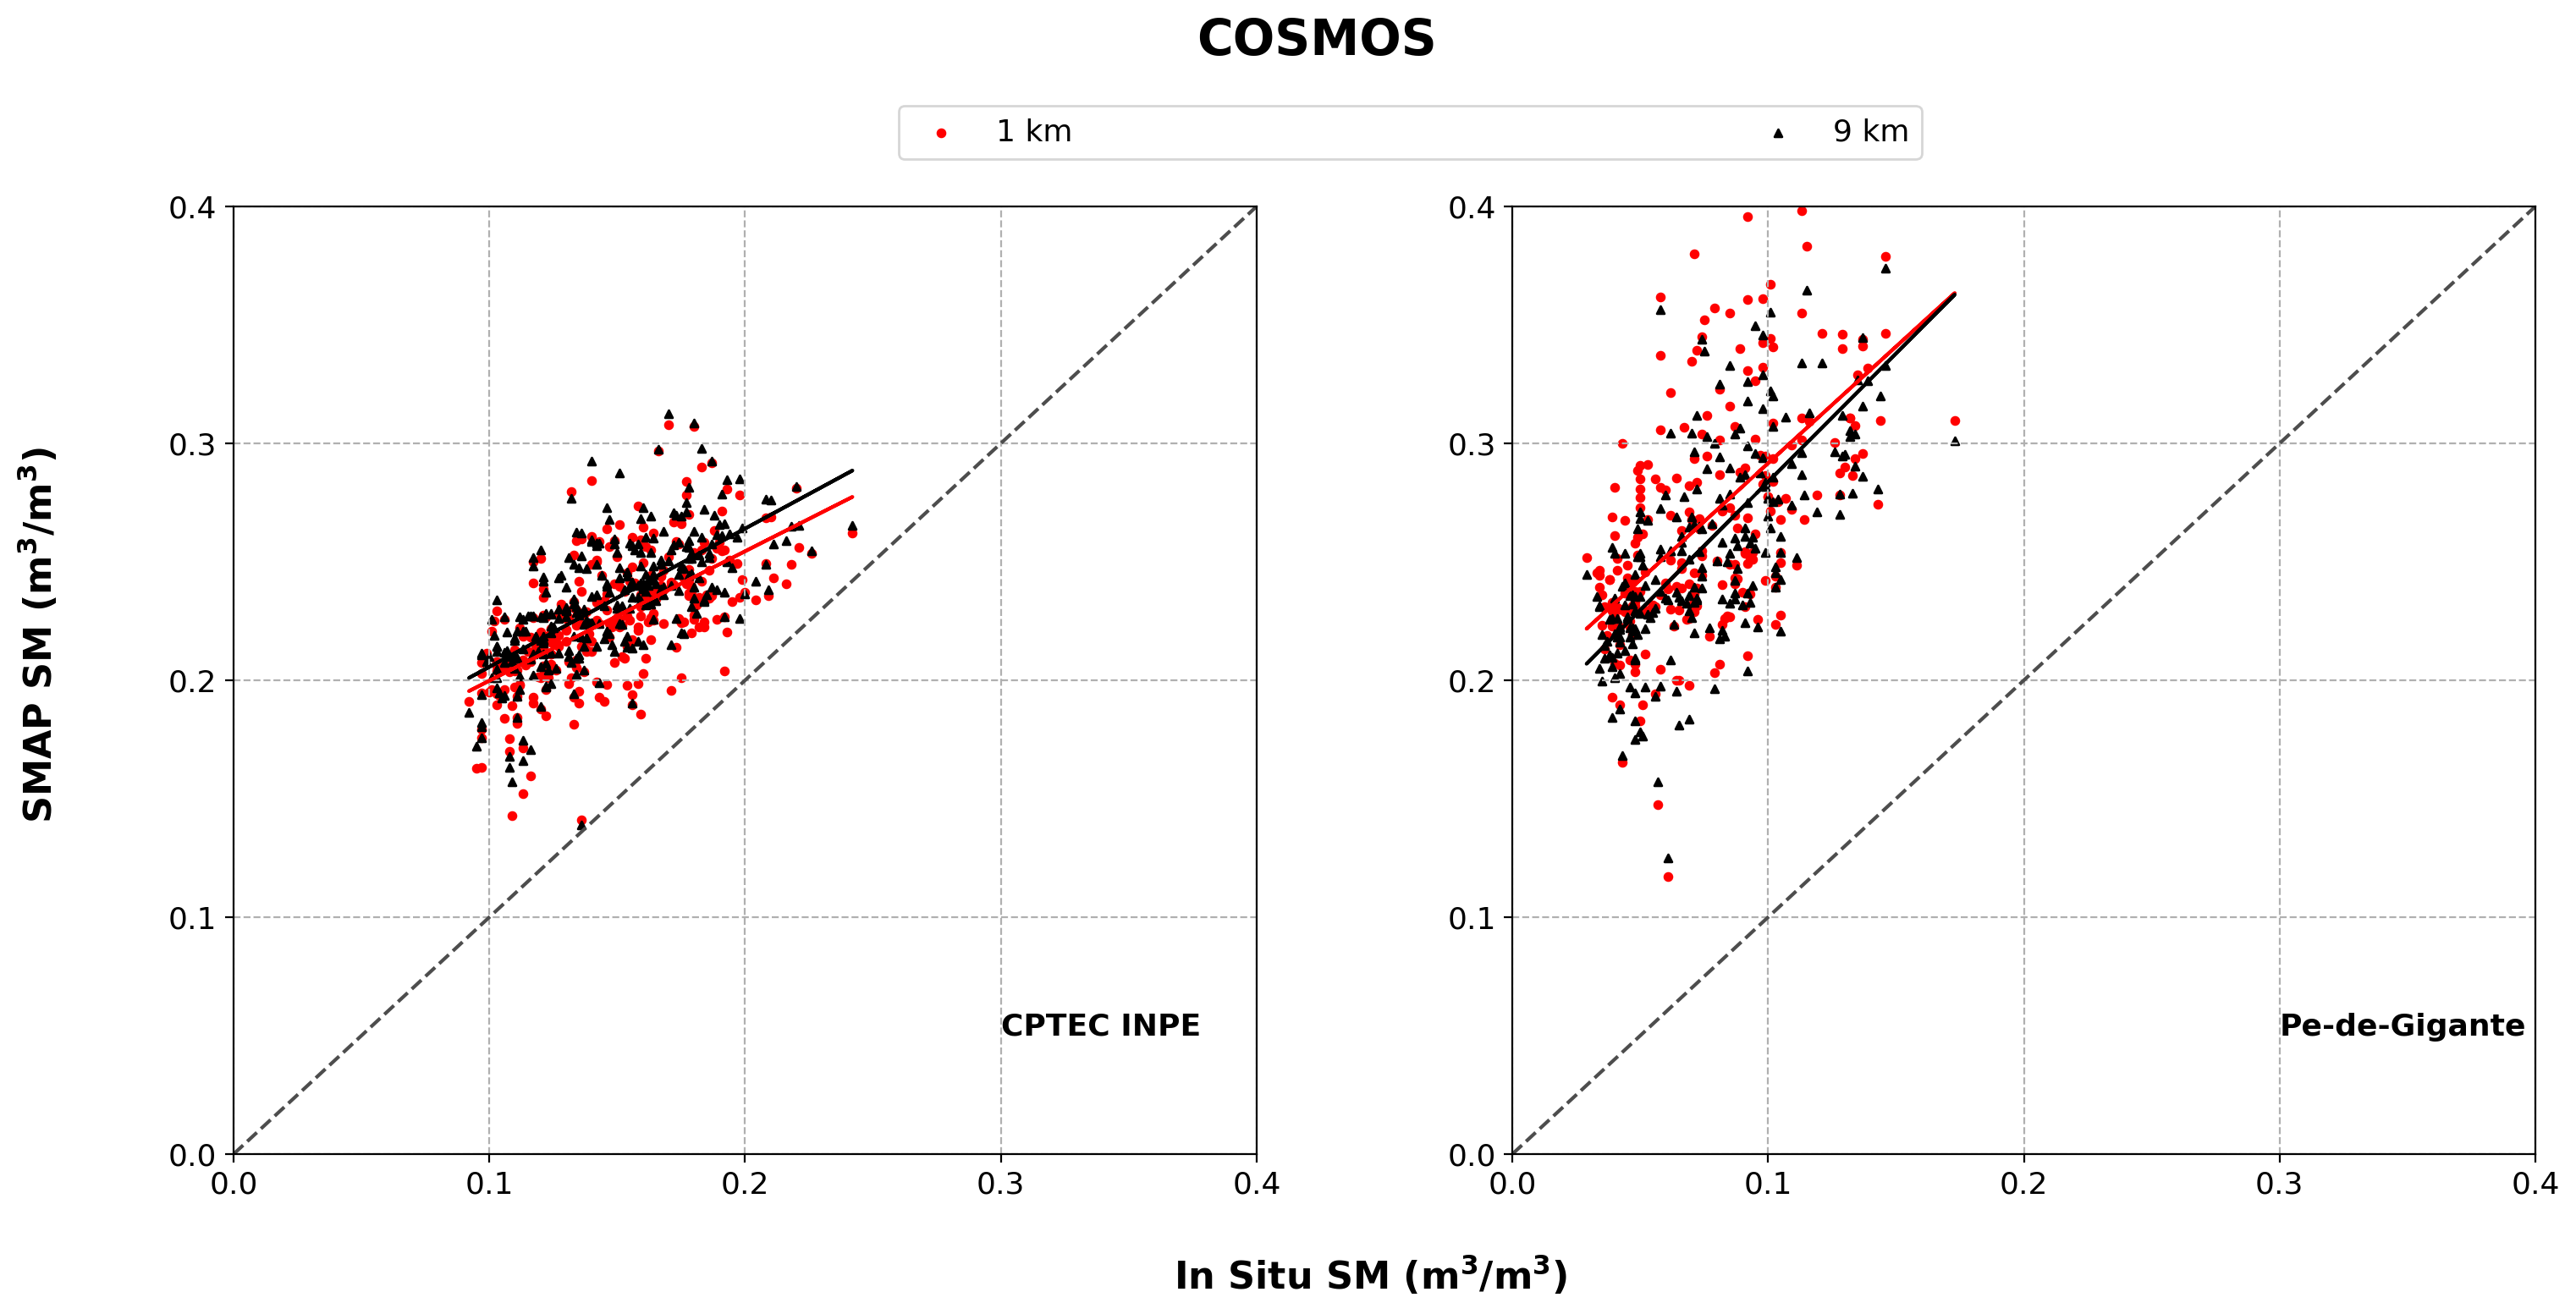

In [27]:
# 4.2 subplots
df_stat_1km = pd.read_excel(path_results + '/stat_1km_new.xlsx', index_col=0)
df_stat_9km = pd.read_excel(path_results + '/stat_9km_new.xlsx', index_col=0)

network_name = network_unique
site_ind = [[0, 1]]
# network_name = list(stn_slc_all_unique)
# site_ind = stn_slc_all_group

for inw in range(len(site_ind)):
    fig = plt.figure(figsize=(16, 8), dpi=200)
    plt.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.85, hspace=0.25, wspace=0.25)
    for ist in range(len(site_ind[inw])):

        x = np.array(df_smap_insitu_sta_am.iloc[site_ind[inw][ist], 2:], dtype=np.float64)
        x[x == 0] = np.nan
        y1 = np.array(df_smap_1km_sta_am.iloc[site_ind[inw][ist], 2:], dtype=np.float64)
        y2 = np.array(df_smap_9km_sta_am.iloc[site_ind[inw][ist], 2:], dtype=np.float64)
        ind_nonnan = np.where(~np.isnan(x) & ~np.isnan(y1) & ~np.isnan(y2))[0]

        x = x[ind_nonnan]
        y1 = y1[ind_nonnan]
        y2 = y2[ind_nonnan]

        slope_1, intercept_1, r_value_1, p_value_1, std_err_1 = stats.linregress(x, y1)
        y1_estimated = intercept_1 + slope_1 * x
        number_1 = len(y1)
        r_sq_1 = r_value_1 ** 2
        ubrmse_1 = np.sqrt(np.mean((x - y1_estimated) ** 2))
        bias_1 = np.mean(x - y1)
        conf_int_1 = std_err_1 * 1.96  # From the Z-value
        stat_array_1 = [number_1, r_sq_1, ubrmse_1, bias_1, p_value_1, conf_int_1]

        slope_2, intercept_2, r_value_2, p_value_2, std_err_2 = stats.linregress(x, y2)
        y2_estimated = intercept_2 + slope_2 * x
        number_2 = len(y2)
        r_sq_2 = r_value_2 ** 2
        ubrmse_2 = np.sqrt(np.mean((x - y2_estimated) ** 2))
        bias_2 = np.mean(x - y2)
        conf_int_2 = std_err_2 * 1.96  # From the Z-value
        stat_array_2 = [number_2, r_sq_2, ubrmse_2, bias_2, p_value_2, conf_int_2]

        ax = fig.add_subplot(len(site_ind[inw])//2, 2, ist+1)
        sc1 = ax.scatter(x, y1, s=10, c='r', marker='o', label='1 km')
        sc2 = ax.scatter(x, y2, s=10, c='k', marker='^', label='9 km')
        ax.plot(x, intercept_1+slope_1*x, '-', color='r')
        ax.plot(x, intercept_2+slope_2*x, '-', color='k')

        plt.xlim(0, 0.4)
        ax.set_xticks(np.arange(0, 0.5, 0.1))
        plt.ylim(0, 0.4)
        ax.set_yticks(np.arange(0, 0.5, 0.1))
        ax.tick_params(axis='both', which='major', labelsize=13)
        ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
        plt.grid(linestyle='--')
        ax.text(0.3, 0.05, df_smap_1km_sta_am.index[site_ind[inw][ist]].replace('_', ' '), fontsize=13, fontweight='bold')

    # add all legends together
    handles = [sc1] + [sc2]
    labels = [l.get_label() for l in handles]
    # leg = plt.legend([sc1, sc2, sc3], labels, loc=(-0.6, 3.55), mode="expand", borderaxespad=0, ncol=3, prop={"size": 13})
    leg = plt.legend([sc1, sc2], labels, loc=(-0.6, 1.05), mode="expand", borderaxespad=0, ncol=3, prop={"size": 13})

    fig.text(0.52, 0.05, 'In Situ SM ($\mathregular{m^3/m^3)}$', ha='center', fontsize=16, fontweight='bold')
    fig.text(0.02, 0.4, 'SMAP SM ($\mathregular{m^3/m^3)}$', rotation='vertical', fontsize=16, fontweight='bold')
    plt.suptitle(network_name[inw], fontsize=21, y=0.99, fontweight='bold')
    plt.savefig(path_results + '/' + network_name[inw] + '.png')
    plt.show()
    plt.close(fig)

In [28]:
# 4.3.1 Make the time-series plots
# Generate index tables for calculating monthly averages
monthly_seq = np.reshape(daysofmonth_seq, (1, -1), order='F')
monthly_seq = monthly_seq[:, 3:] # Remove the first 3 months in 2015
monthly_seq_cumsum = np.cumsum(monthly_seq)
array_allnan = np.empty([size_validation[0], 3], dtype='float32')
array_allnan[:] = np.nan

smap_insitu_am_split = \
    np.hsplit(np.array(df_smap_insitu_sta_am.iloc[:, 2:], dtype='float32'), monthly_seq_cumsum) # split by each month
smap_insitu_am_monthly = [np.nanmean(smap_insitu_am_split[x], axis=1) for x in range(len(smap_insitu_am_split))]
smap_insitu_am_monthly = np.stack(smap_insitu_am_monthly, axis=0)
smap_insitu_am_monthly = np.transpose(smap_insitu_am_monthly, (1, 0))
smap_insitu_am_monthly = smap_insitu_am_monthly[:, :-1]
smap_insitu_am_monthly = np.concatenate([array_allnan, smap_insitu_am_monthly], axis=1)

smap_1km_am_split = \
    np.hsplit(np.array(df_smap_1km_sta_am.iloc[:, 2:], dtype='float32'), monthly_seq_cumsum) # split by each month
smap_1km_am_monthly = [np.nanmean(smap_1km_am_split[x], axis=1) for x in range(len(smap_1km_am_split))]
smap_1km_am_monthly = np.stack(smap_1km_am_monthly, axis=0)
smap_1km_am_monthly = np.transpose(smap_1km_am_monthly, (1, 0))
smap_1km_am_monthly = smap_1km_am_monthly[:, :-1]
smap_1km_am_monthly = np.concatenate([array_allnan, smap_1km_am_monthly], axis=1)

smap_9km_am_split = \
    np.hsplit(np.array(df_smap_9km_sta_am.iloc[:, 2:], dtype='float32'), monthly_seq_cumsum) # split by each month
smap_9km_am_monthly = [np.nanmean(smap_9km_am_split[x], axis=1) for x in range(len(smap_9km_am_split))]
smap_9km_am_monthly = np.stack(smap_9km_am_monthly, axis=0)
smap_9km_am_monthly = np.transpose(smap_9km_am_monthly, (1, 0))
smap_9km_am_monthly = smap_9km_am_monthly[:, :-1]
smap_9km_am_monthly = np.concatenate([array_allnan, smap_9km_am_monthly], axis=1)


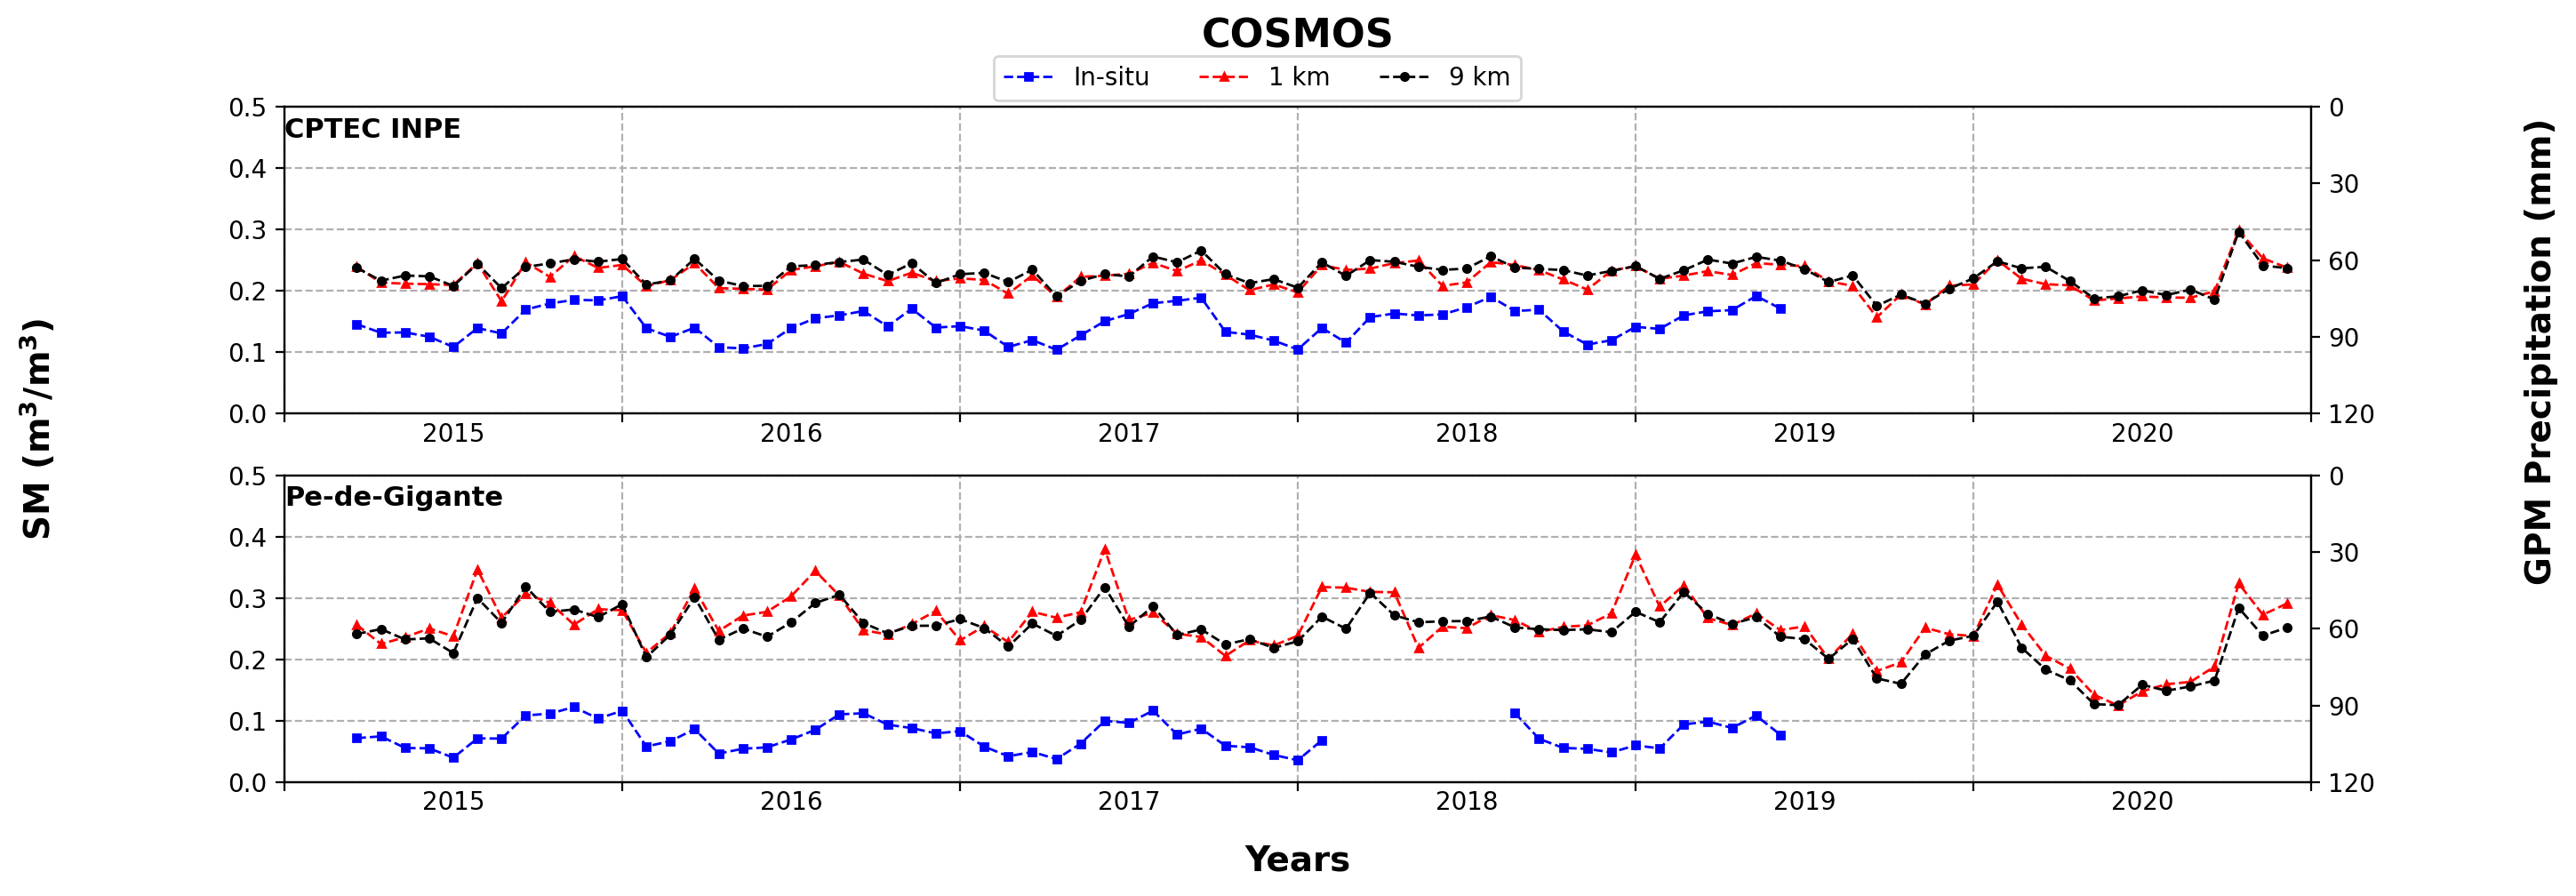

In [29]:
# 4.3.2 Make the time-series plots
network_name = network_unique
site_ind = [[0, 1]] # Selected stations from the network

# Network 1
for inw in [0]:#range(len(site_ind)):

    fig = plt.figure(figsize=(15, 5), dpi=200)
    plt.subplots_adjust(left=0.12, right=0.88, bottom=0.12, top=0.88, hspace=0.2, wspace=0.2)
    for ist in range(len(site_ind[inw])):

        x = smap_insitu_am_monthly[site_ind[inw][ist], :]
        y1 = smap_1km_am_monthly[site_ind[inw][ist], :]
        y2 = smap_9km_am_monthly[site_ind[inw][ist], :]
        # z = smap_gpm_monthly[site_ind[inw][ist], :]

        ax = fig.add_subplot(2, 1, ist+1)
        lns1 = ax.plot(x, c='b', marker='s', label='In-situ', markersize=3, linestyle='--', linewidth=1)
        lns2 = ax.plot(y1, c='r', marker='^', label='1 km', markersize=3, linestyle='--', linewidth=1)
        lns3 = ax.plot(y2, c='k', marker='o', label='9 km', markersize=3, linestyle='--', linewidth=1)

        ax.text(0, 0.45, df_smap_1km_sta_am.index[site_ind[inw][ist]].replace('_', ' '), fontsize=11, fontweight='bold')

        plt.xlim(0, len(x))
        ax.set_xticks(np.arange(0, len(x)+12, len(x)//6))
        ax.set_xticklabels([])
        labels = ['2015', '2016', '2017', '2018', '2019', '2020']
        mticks = ax.get_xticks()
        ax.set_xticks((mticks[:-1] + mticks[1:]) / 2, minor=True)
        ax.tick_params(axis='x', which='minor', length=0)
        ax.set_xticklabels(labels, minor=True)

        plt.ylim(0, 0.5)
        ax.set_yticks(np.arange(0, 0.6, 0.1))
        ax.tick_params(axis='y', labelsize=10)
        ax.grid(linestyle='--')

        ax2 = ax.twinx()
        ax2.set_ylim(0, 120)
        ax2.invert_yaxis()
        ax2.set_yticks(np.arange(0, 150, 30))
        # lns4 = ax2.bar(np.arange(len(x)), z, width=0.8, color='cornflowerblue', label='Precipitation', alpha=0.5)
        ax2.tick_params(axis='y', labelsize=10)

    # add all legends together
    # handles = lns1 + lns2 + [lns4]
    handles = lns1 + lns2 + lns3
    labels = [l.get_label() for l in handles]

    plt.legend(handles, labels, loc=(0.35, 2.22), borderaxespad=0, ncol=4, prop={"size": 10})
    fig.text(0.5, 0.02, 'Years', ha='center', fontsize=14, fontweight='bold')
    fig.text(0.02, 0.4, 'SM ($\mathregular{m^3/m^3)}$', rotation='vertical', fontsize=14, fontweight='bold')
    fig.text(0.96, 0.35, 'GPM Precipitation (mm)', rotation='vertical', fontsize=14, fontweight='bold')
    plt.suptitle(network_name[inw], fontsize=16, y=0.98, fontweight='bold')
    plt.savefig(path_results + '/' + network_name[inw] + '_tseries' + '.png')
    plt.show()
    plt.close(fig)

In [ ]:
# ########################################################################################################################
# # Calculate and write monthly averaged 1km/9km SMAP SM to disk
# daysofmonth_seq_cumsum_ind = np.copy(daysofmonth_seq_cumsum)
# daysofmonth_seq_cumsum_ind[:, 0] = daysofmonth_seq_cumsum_ind[:, 0] - 90
# daysofmonth_seq_cumsum_ind = [list(daysofmonth_seq_cumsum_ind[:, x]) for x in range(daysofmonth_seq_cumsum_ind.shape[1])]
# del(daysofmonth_seq_cumsum_ind[0][0:3])
# daysofmonth_seq_cumsum_ind = [[0] + daysofmonth_seq_cumsum_ind[x] for x in range(len(daysofmonth_seq_cumsum_ind))]

# # 1 km
# # smap_1km_all = []
# for iyr in range(len(yearname)):

#     os.chdir(path_smap_1km +'/' + str(yearname[iyr]))
#     tif_files = sorted(glob.glob('*.tif'))

#     src_profile = rasterio.open(tif_files[0]).profile
#     src_profile.update(count=1)
#     smap_1km_1year = []
#     for idt in range(len(tif_files)):
#         smap_1km_1day = rasterio.open(tif_files[idt]).read()
#         smap_1km_1day = np.nanmean(smap_1km_1day, axis=0)
#         smap_1km_1year.append(smap_1km_1day)
#         del(smap_1km_1day)
#         print(tif_files[idt])

#     # Generate monthly averaged data
#     # smap_1km_1year_avg = []
#     for imo in range(len(daysofmonth_seq_cumsum_ind[iyr])-1):
#         smap_1km_avg = smap_1km_1year[daysofmonth_seq_cumsum_ind[iyr][imo]:daysofmonth_seq_cumsum_ind[iyr][imo+1]]
#         smap_1km_avg = np.nanmean(np.stack(smap_1km_avg, axis=0), axis=0)
#         # smap_1km_1year_avg.append(smap_1km_avg)
#         smap_1km_avg = np.expand_dims(smap_1km_avg, axis=0)
#         # Write to file
#         if iyr == 0:
#             filename = 'smap_sm_1km_ds_' + str(yearname[iyr]) + '_' + str(monthnum[imo+3]).zfill(2)
#         else:
#             filename = 'smap_sm_1km_ds_' + str(yearname[iyr]) + '_' + str(monthnum[imo]).zfill(2)
#         dst_writer = rasterio.open(path_output + '/la_plata_1km_monthly/' + filename + '.tif', 'w', **src_profile)
#         dst_writer.write(smap_1km_avg)
#         dst_writer = None
#         print(filename)
#         del(smap_1km_avg)

#     # smap_1km_all.append(smap_1km_1year_avg)
#     del(smap_1km_1year)



In [ ]:
# # 9 km
# # smap_9km_all = []
# for iyr in range(len(yearname)):

#     os.chdir(path_smap_9km +'/' + str(yearname[iyr]))
#     tif_files = sorted(glob.glob('*.tif'))

#     src_profile = rasterio.open(tif_files[0]).profile
#     src_profile.update(count=1)
#     smap_9km_1year = []
#     for idt in range(len(tif_files)):
#         smap_9km_1day = rasterio.open(tif_files[idt]).read()
#         smap_9km_1day = np.nanmean(smap_9km_1day, axis=0)
#         smap_9km_1year.append(smap_9km_1day)
#         del(smap_9km_1day)
#         print(tif_files[idt])

#     # Generate monthly averaged data
#     # smap_9km_1year_avg = []
#     for imo in range(len(daysofmonth_seq_cumsum_ind[iyr])-1):
#         smap_9km_avg = smap_9km_1year[daysofmonth_seq_cumsum_ind[iyr][imo]:daysofmonth_seq_cumsum_ind[iyr][imo+1]]
#         smap_9km_avg = np.nanmean(np.stack(smap_9km_avg, axis=0), axis=0)
#         # smap_9km_1year_avg.append(smap_9km_avg)
#         smap_9km_avg = np.expand_dims(smap_9km_avg, axis=0)
#         # Write to file
#         if iyr == 0:
#             filename = 'smap_sm_9km_ds_' + str(yearname[iyr]) + '_' + str(monthnum[imo+3]).zfill(2)
#         else:
#             filename = 'smap_sm_9km_ds_' + str(yearname[iyr]) + '_' + str(monthnum[imo]).zfill(2)
#         dst_writer = rasterio.open(path_output + '/la_plata_9km_monthly/' + filename + '.tif', 'w', **src_profile)
#         dst_writer.write(smap_9km_avg)
#         dst_writer = None
#         print(filename)
#         del(smap_9km_avg)

#     # smap_9km_all.append(smap_9km_1year_avg)
#     del(smap_9km_1year)
